In [3]:
from skimage.measure import regionprops
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
from skimage import io
from skimage.morphology.selem import square
from skimage.morphology import binary_erosion
from scipy.ndimage import median_filter
from skimage import measure


def remove_salt_and_pepper(img):
    # Apply median filter to remove the salt and pepper noise
    n = img.shape[0]
    x = np.random.uniform(0, n - 1, int(0.1 * img.size)).astype(np.int)
    y = np.random.uniform(0, n - 1, int(0.1 * img.size)).astype(np.int)

    corrupted = img.copy()
    corrupted[y[:len(y) // 2], x[:len(x) // 2]] = 0
    corrupted[y[len(y) // 2:], x[len(x) // 2:]] = 255

    img = median_filter(corrupted, 6)
    return img


def remove_grid(img):
    # Compute fourier transform and log power spectrum
    image_ft = fft2(img)
    image_ft_spectrum = fftshift(np.log10(1 + np.abs(image_ft) ** 2))

    # Remove white spots in the power spectrum except the center (by supressing the center with a gauassian mask)
    middle_y, middle_x = np.mgrid[-img.shape[0] // 2:img.shape[0] // 2, -img.shape[1] // 2:img.shape[1] // 2]
    suppression_for_middle = 1 - np.exp(-(middle_y ** 2 + middle_x ** 2) / (2 * 20 ** 2))
    image_ft_middle_suppressed = image_ft_spectrum * suppression_for_middle

    image_ft_white_spot_coodinates = np.nonzero(image_ft_middle_suppressed > 10)
    for white_spot in np.transpose(image_ft_white_spot_coodinates):
        white_spot_y, white_spot_x = white_spot
        image_ft_spectrum[white_spot_y - 2:white_spot_y + 2, white_spot_x - 2:white_spot_x + 2] = 0

    # Plot the power spectrum
    ax[2].set_title('Modified Fourier Spectrum for Grid removal')
    ax[2].imshow(image_ft_spectrum, interpolation="none")

    # Inverse power spectrum and fourier transform to get the image
    image_absolute = np.sqrt(10 ** ifftshift(image_ft_spectrum) - 1)
    image_ft = image_absolute * np.cos(np.angle(image_ft)) + image_absolute * np.sin(np.angle(image_ft)) * 1j
    img = ifft2(image_ft).real

    return img


def increase_contrast(img):
    for x, row in enumerate(img):
        for y, data in enumerate(row):
            img[x][y] = np.clip(((data - 128) * 2.6) + 128, 0, 255)

    return img


def apply_thresholding(img):
    # Determinate the threshold border automatically with help of the histogram
    histogram, _ = np.histogram(img, bins=np.arange(257))
    threshold_border = 128
    threshold_last = -1000

    while np.abs(threshold_border - threshold_last) > 0.5:
        m_1 = np.sum(np.arange(threshold_border) * histogram[:threshold_border]) / np.sum(histogram[:threshold_border])
        m_2 = np.sum(np.arange(threshold_border, 256) * histogram[threshold_border:]) / np.sum(
            histogram[threshold_border:])
        threshold_last = threshold_border
        threshold_border = int((m_1 + m_2) / 2 + 0.5)

    # Apply thresholding on the image to get a binary image
    img[img < threshold_border] = 0
    img[img >= threshold_border] = 1

    return img


def separate_peppercorns(img):
    # Invert the image to be able to apply the erosion
    img = 1 - img

    # Apply erosion only on label-areas, which are bigger than 150 pixels
    # to avoid losing peppercorns through erosion
    img_labels = measure.label(img)
    removed_areas = np.zeros_like(img_labels)

    for i in range(0, 25):
        img_labels, remaining_peppercorns = measure.label(img_labels, return_num=True)
        if remaining_peppercorns == 0:
            break

        for label_region in regionprops(img_labels):
            if label_region.area < 150:
                index = np.where(img_labels == label_region.label)
                removed_areas[index] = 1
                img_labels[index] = 0

        img_labels[img_labels > 0] = 1

        img_labels = binary_erosion(img_labels, square(2))

    # Put the image of eroded peppercorns back together
    img = img_labels + removed_areas

    # Remove noise artifacts which were created by the erosion
    img_labels = measure.label(img)
    for label_region in regionprops(img_labels):
        if label_region.area < 10:
            index = np.where(img_labels == label_region.label)
            img[index] = 0

    # Invert the image again and return it
    return 1 - img


def count_peppercorns(img):
    # Count the number of peppercorns in the image
    img_labels, peppercorns_count = measure.label(img, background=1, return_num=True)

    # Mark the centers of the peppercorns with a colored dot (just for visualization in result image)
    for label_region in regionprops(img_labels):
        ax[6].scatter(label_region.centroid[1], label_region.centroid[0])

    return peppercorns_count


C:\Users\mawob\AppData\Local\Temp/ipykernel_22612/3775637608.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.random.uniform(0, n - 1, int(0.1 * img.size)).astype(np.int)
C:\Users\mawob\AppData\Local\Temp/ipykernel_22612/3775637608.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

Number of Peppercorns: 110 



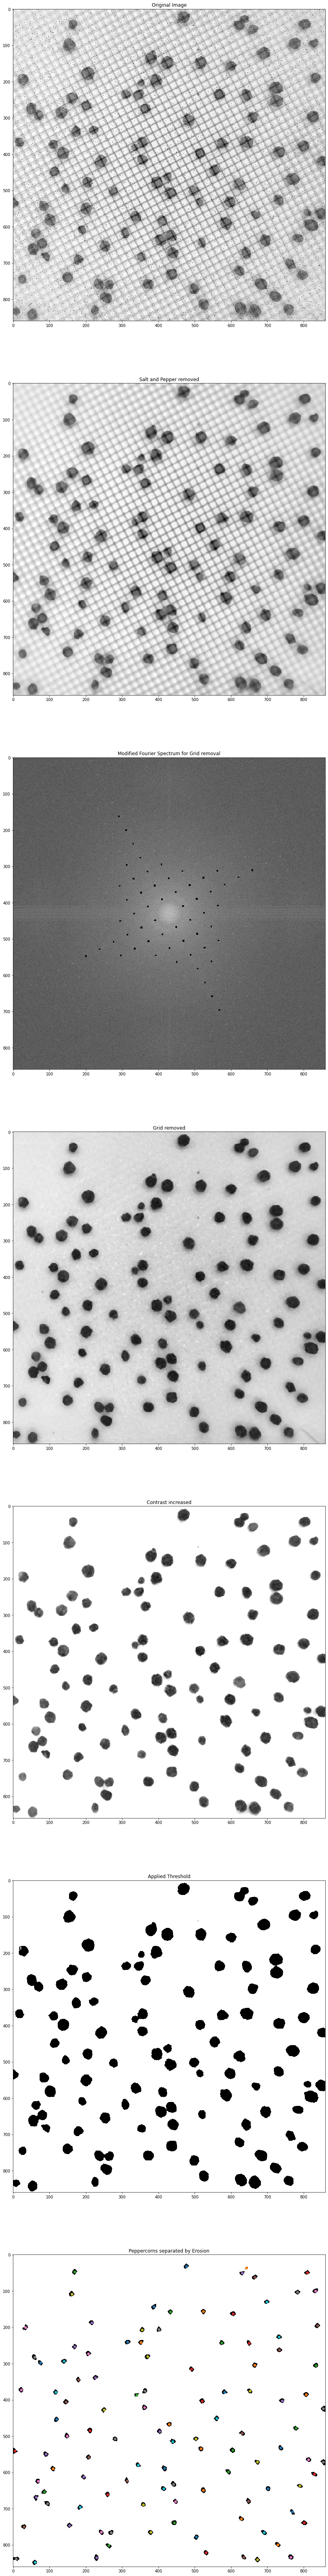

In [4]:
# Import/Read Image
image = io.imread("input.tif")

# Create Plots
figure, ax = plt.subplots(7, 1)
figure.set_size_inches(120, 120)
plt.gray()

# Apply steps and plot the results to make counting the peppercorns possible
ax[0].set_title('Original Image')
ax[0].imshow(image, interpolation="none")

image = remove_salt_and_pepper(image)

ax[1].imshow(image, interpolation="none")
ax[1].set_title('Salt and Pepper removed')

image = remove_grid(image)

ax[3].imshow(image, interpolation="none")
ax[3].set_title('Grid removed')

image = increase_contrast(image)

ax[4].set_title('Contrast increased')
ax[4].imshow(image, interpolation="none")

image = apply_thresholding(image)

ax[5].imshow(image, interpolation="none")
ax[5].set_title('Applied Threshold')

image = separate_peppercorns(image)

ax[6].imshow(image, interpolation="none")
ax[6].set_title('Peppercorns separated by Erosion')

# Counting the peppercorns and print the result
peppercornsCount = count_peppercorns(image)
print("Number of Peppercorns:", peppercornsCount, "\n")
